## Spectrum analysis pipeline for aerosol measurement
- The energy calibration for HPGe spetrum
- Limits calculation

In [1]:
from utils.read_spectrum import read_simu,readCNF
from utils.PoissonDenoise import VSTDenoise
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np

## Take an HPGe measurement  for an aerosol sample

Measurement started: 08-04-2020, 12:44:02
Counting time: 560000.0


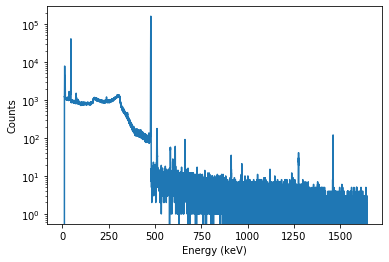

In [2]:
x = readCNF('real_data/ex_x.cnf')
plt.semilogy(x['energy'],x['counts'])
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
print('Measurement started:',x['start_time'])
print('Counting time:',x['live_time'])

## Background spectrum

Measurement started: 01-04-2020, 14:12:34
Counting time: 560000.0


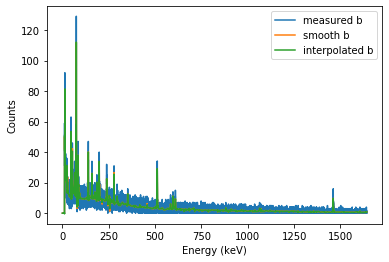

In [3]:
b_measure = readCNF('real_data/ex_b.cnf')
b_smooth = VSTDenoise(np.double(b_measure['counts']),J=6,kmad=3)

f = interpolate.interp1d(b_measure['energy'],b_smooth,bounds_error=False,kind='cubic',fill_value=0) 
b0 = f(x['energy'])

plt.plot(b_measure['energy'],b_measure['counts'],label='measured b')
plt.plot(b_measure['energy'],b_smooth,label='smooth b')
plt.plot(x['energy'],b0,label='interpolated b')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.legend()
print('Measurement started:',b_measure['start_time'])
print('Counting time:',b_measure['live_time'])

## Spectral signatures simulated with MCNP-CP
- The normailized spectra corresponds to energy response of unit Particle
- Activity (Bq) = mixing weights/counting time

In [4]:
phi_dic = []
phi_dic.append(read_simu('real_data/Be7.o')['counts'])
phi_dic.append(read_simu('real_data/Na22.o')['counts'])
phi_dic.append(read_simu('real_data/K40.o')['counts'])
phi_dic.append(read_simu('real_data/Cs137.o')['counts'])
phi_dic.append(read_simu('real_data/Pb210.o')['counts'])
phi_dic.append(read_simu('real_data/Tl208.o')['counts'])
phi_dic.append(read_simu('real_data/Bi212.o')['counts'])
phi_dic.append(read_simu('real_data/Pb212.o')['counts'])
phi_dic.append(read_simu('real_data/Bi214.o')['counts'])
phi_dic.append(read_simu('real_data/Pb214.o')['counts'])
phi_dic.append(read_simu('real_data/Ac228.o')['counts'])
phi_dic.append(read_simu('real_data/Pbx.o')['counts'])
phi_sig = np.asarray(phi_dic).T
e_phi = 1000*read_simu('real_data/Be7.o')['energy'] # identical energy bins for simulations
print('Dimension:',phi_sig.shape)

Dimension: (27199, 12)


In [5]:
from script_unmix.unmix_algo import chambolle_pock
from utils.operators import prox_Nonnegative,Lpoisson,dual_prox,grad_LS
def algo_cp(phi_in,x_in,b_in):
    phi = np.copy(phi_in)
    x = np.copy(x_in)
    b = np.copy(b_in)
    
    N = np.linalg.norm(np.dot(phi.T,phi))
    phi = phi/N
    L = np.linalg.norm(np.dot(phi.T,phi),ord=2)
    sigma = 5e-5
    tau = (.9/(sigma*L))

    nP = np.shape(phi)
    a_initial = 1./nP[1]*np.ones((nP[1]))
    K = lambda y: np.dot(phi,y)
    KT = lambda y: np.dot(phi.T,y)
    prox_g = prox_Nonnegative
    prox_f = lambda a,step:Lpoisson(a+b,step)(x)-b
    prox_fC = lambda u,sigma: dual_prox(prox_f)(u,sigma)
    a_estim,a_list = chambolle_pock(prox_fC, prox_g, a_initial, K, KT, sigma,tau,n_item=0,tol=1e-10,verb=True,error_list=False)
    a_estim = a_estim/N
    return a_estim

In [6]:
from script_metrology.phi_calibration import spectral_analysis
e0 = 30
ind_dic = np.array([[475,480],[1271,1278],[1456,1470],[658,666],[45.5,48]]) # the peak region energy     
E = [477.6,1274.5,1460.8,661.7,46.5]
ind_r = np.arange(5) 

In [7]:
act = spectral_analysis(phi=phi_sig, x=x, b=b0, b_measure=b_measure, e0=e0, e_phi=e_phi, unmix_algo=algo_cp,
                  ind_dic=ind_dic, E=E, ind_r=ind_r)

iteration: 0 --error: 626.0375149587861
iteration: 1000 --error: 0.00040288384342560023
iteration: 2000 --error: 0.00012179535503251408
iteration: 3000 --error: 5.578819717689565e-05
iteration: 4000 --error: 2.780821996252974e-05
iteration: 5000 --error: 1.4913297347658939e-05
iteration: 6000 --error: 8.19009898778714e-06
iteration: 7000 --error: 4.53414086147658e-06
iteration: 8000 --error: 2.5172253493502364e-06
iteration: 9000 --error: 1.3907130811545797e-06
iteration: 10000 --error: 7.628543049332999e-07
iteration: 11000 --error: 4.1402924296161635e-07
iteration: 12000 --error: 2.210074539599827e-07
iteration: 13000 --error: 1.1547093644835744e-07
iteration: 14000 --error: 5.7382909783635277e-08
iteration: 15000 --error: 2.640099833724403e-08
iteration: 16000 --error: 3.012196642858883e-08
iteration: 17000 --error: 3.07307154495997e-08
iteration: 18000 --error: 2.8594781481238178e-08
iteration: 19000 --error: 2.561126974628073e-08
iteration: 20000 --error: 2.2522837562528014e-08
it

iteration: 26000 --error: 9.78162156289551e-09
iteration: 27000 --error: 8.63574392318263e-09
iteration: 28000 --error: 7.660664208008513e-09
iteration: 29000 --error: 6.830609334444392e-09
iteration: 30000 --error: 6.128419979329482e-09
iteration: 31000 --error: 5.520033857252105e-09
iteration: 32000 --error: 4.990208524481417e-09
iteration: 33000 --error: 4.526537833495372e-09
iteration: 34000 --error: 4.118890522750529e-09
iteration: 35000 --error: 3.758953332456793e-09
iteration: 36000 --error: 3.4398670923349577e-09
iteration: 37000 --error: 3.1559378176782975e-09
iteration: 38000 --error: 2.9024110948586056e-09
iteration: 39000 --error: 2.6752940324933173e-09
iteration: 40000 --error: 2.4712143475185826e-09
iteration: 41000 --error: 2.287308622025007e-09
iteration: 42000 --error: 2.1211343841415272e-09
iteration: 43000 --error: 1.9705980729675304e-09
iteration: 44000 --error: 1.8338976474423531e-09
iteration: 45000 --error: 1.7094757300655904e-09
iteration: 46000 --error: 1.59598

## Spectrum analysis results 

In [8]:
from script_metrology.limits import sd_calcul
from script_metrology.limits import rn_fisher
Name = ['Be7','Na22','K40','Cs137','Pb210','Tl208','Bi212','Pb212','Bi214','Pb214','Ac228','Pb_x']
sd = sd_calcul(act['x'],act['A'],act['b'],act['phi'],alpha=0.025)
std_fisher = rn_fisher(act['x'],act['A'],act['b'],act['phi'])
# example of uncertainty terms 
r_err = np.array([0.05,0.05,0.02,0.05,0.04]) # uncertainty budget of aerosol measurements
uncert  = np.zeros(len(act['A']))
for r in range(len(act['A'])):
    uncert[r] = act['A'][r]*(np.sqrt((2*std_fisher[r]/act['A'][r])**2+sum(r_err**2)))

In [9]:
# Here we take the max value between SD calculated with projection w1 and w2
R = []
for r in range(len(act['A'])):
    if act['A'][r]< max(sd['w1'][r], act['A'][r]<sd['w2'][r]):
        R.append('<SD')
    else:
        R.append('')
R1 = []
for r in range(len(act['A'])):
    if act['A'][r]-uncert[r]< max(sd['w1'][r], act['A'][r]<sd['w2'][r]):
        R1.append('(-uncert)<SD')
    else:
        R1.append('')
print('Sample:', x['sample_code'])
print('Start time:', x['start_time'])
print('Counting time:',x['live_time'])
print('Unit: Bq')
print("-"*70)
delim = '|'
header = ['{:<6}'.format(''), "{:>10}".format('Activity'),"{:>10}".format('Uncert'),
          "{:>10}".format('SD (w1)'),"{:>10}".format('SD (w2)'),"{:>7}".format(''),"{:>7}".format('')]
print(delim.join(header))
print("-"*70)

for r in range(len(act['A'])):
    header = ['{:<6}'.format(Name[r]),"{0:10.3f}".format(act['A'][r]/act['t']),"{0:10.3f}".format(uncert[r]/act['t']),"{0:10.3f}".format(sd['w1'][r]/act['t']),
             "{0:10.3f}".format(sd['w2'][r]/act['t']),"{:>7}".format(R[r]),"{:7}".format(R1[r])]
    print(delim.join(header))
    print("-"*70)

Sample: K20OAT14-80A1
Start time: 08-04-2020, 12:44:02
Counting time: 560000.0
Unit: Bq
----------------------------------------------------------------------
      |  Activity|    Uncert|   SD (w1)|   SD (w2)|       |       
----------------------------------------------------------------------
Be7   |   359.387|    35.030|     0.005|     0.063|       |       
----------------------------------------------------------------------
Na22  |     0.049|     0.005|     0.002|     0.001|       |       
----------------------------------------------------------------------
K40   |     1.139|     0.120|     0.063|     0.026|       |       
----------------------------------------------------------------------
Cs137 |     0.052|     0.006|     0.003|     0.001|       |       
----------------------------------------------------------------------
Pb210 |    34.658|     3.381|     0.028|     0.043|       |       
----------------------------------------------------------------------
Tl208 |     0